In [19]:
# librairies

import xarray as xr
import numpy as np
import pandas as pd
import glob
from datetime import datetime
import gc
import data_process
from tqdm import tqdm
import matplotlib.pyplot as plt

# Loop

In [2]:
# paths
upath = '/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF/ERA5/SL/10m_u_component_of_wind/'
vpath = '/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF/ERA5/SL/10m_v_component_of_wind/'

# Date specification
year = np.arange(1990,2021,1)
target_month = 2
target_day = 1

In [12]:
max_winds_europe = []
for yearz in tqdm(year):
    # import data
    u10path = upath+f'ERA5_{str(yearz)}-{str(target_month)}_10m_u_component_of_wind.nc'
    v10path = vpath+f'ERA5_{str(yearz)}-{str(target_month)}_10m_v_component_of_wind.nc'
    
    # read files with xarray
    u10 = xr.open_dataset(glob.glob(u10path)[0])
    v10 = xr.open_dataset(glob.glob(v10path)[0])

    # parse date
    first_true_index,last_true_index = data_process.parse_date_and_output_list(u10,target_month,target_day)

    # Convert longitude from 0-360 to -180 to 180
    u10['longitude'] = ((u10['longitude'] + 180) % 360) - 180
    v10['longitude'] = ((v10['longitude'] + 180) % 360) - 180
    # Sort the dataset along the new longitude axis
    u10 = u10.sortby('longitude')
    v10 = v10.sortby('longitude')

    # Get the Europe subregion
    u10_europe = u10.sel(latitude=slice(70, 30), longitude=slice(-15, 40))
    v10_europe = v10.sel(latitude=slice(70, 30), longitude=slice(-15, 40))

    # parse date
    u10_europe_date = u10_europe.isel(time=slice(first_true_index, last_true_index + 1))
    v10_europe_date = v10_europe.isel(time=slice(first_true_index, last_true_index + 1))

    # get wind speed
    wspd = (u10_europe_date['10u']**2+v10_europe_date['10v']**2)**(0.5)
    del u10,v10,u10_europe,v10_europe,u10_europe_date,v10_europe_date
    gc.collect()

    # get maximum wind for 1 year
    max_wind_europe = wspd.max(dim='time')

    max_winds_europe.append(max_wind_europe)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:38<00:00,  1.26s/it]


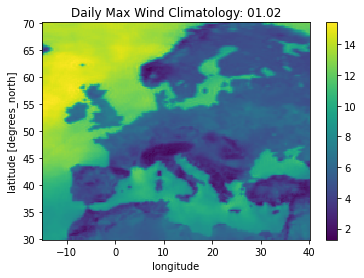

In [20]:
xr.concat(max_winds_europe, dim="time").mean('time').plot()
plt.title('Daily Max Wind Climatology: 01.02')
plt.savefig('./sample_climatology.png',dpi=400)